In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#set aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#load the dataset
#we reload from the CSV to ensure a completely fresh start
df = pd.read_csv('UCI_Credit_Card_final.csv')

#display the first 5 rows to verify headers and data format
print("First 5 rows of the dataset:")
display(df.head())

#display basic information about data types and non-null counts
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,female,university,married,24,2,2,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,2,120000.0,female,university,single,26,0,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,3,90000.0,female,university,single,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,4,50000.0,female,university,married,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,5,50000.0,male,university,married,57,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0



Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  str    
 3   EDUCATION                   29986 non-null  str    
 4   MARRIAGE                    29946 non-null  str    
 5   AGE                         30000 non-null  int64  
 6   PAY_1                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   29850 non-null  float64
 13  BILL_AMT2                  

In [9]:
#display summary statistics for numerical features (transposed for easier reading)
print("\nSummary Statistics:")
display(df.describe().T)

#check for specific missing value counts
print("\nMissing Values Count:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

#check the distribution of the target variable to see if classes are balanced
print("\nTarget Variable Distribution:")
print(df['default.payment.next.month'].value_counts(normalize=True))


Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
ID,30000.0,1.500050e+04,8.660398e+03,1.0,7500.75,15000.5,22500.25,3.000000e+04
LIMIT_BAL,30000.0,1.674843e+05,1.297477e+05,10000.0,50000.00,140000.0,240000.00,1.000000e+06
AGE,30000.0,3.548550e+01,9.217904e+00,21.0,28.00,34.0,41.00,7.900000e+01
PAY_1,30000.0,3.567667e-01,7.605942e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_2,30000.0,3.200333e-01,8.017274e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_3,30000.0,3.040667e-01,7.905890e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_4,30000.0,2.587667e-01,7.611126e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_5,30000.0,2.215000e-01,7.177197e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_6,30000.0,2.265667e-01,7.154378e-01,0.0,0.00,0.0,0.00,8.000000e+00
BILL_AMT1,29850.0,5.124887e+04,7.365806e+04,-165580.0,3570.25,22414.0,67190.00,9.645110e+05



Missing Values Count:
EDUCATION                      14
MARRIAGE                       54
BILL_AMT1                     150
BILL_AMT2                     150
BILL_AMT3                     150
BILL_AMT4                     150
BILL_AMT5                     150
BILL_AMT6                     150
default.payment.next.month     20
dtype: int64

Target Variable Distribution:
default.payment.next.month
0.0    0.778719
1.0    0.221281
Name: proportion, dtype: float64


C:\Users\allam\AppData\Local\Temp\ipykernel_17156\2076886055.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default.payment.next.month', data=df, palette='viridis')


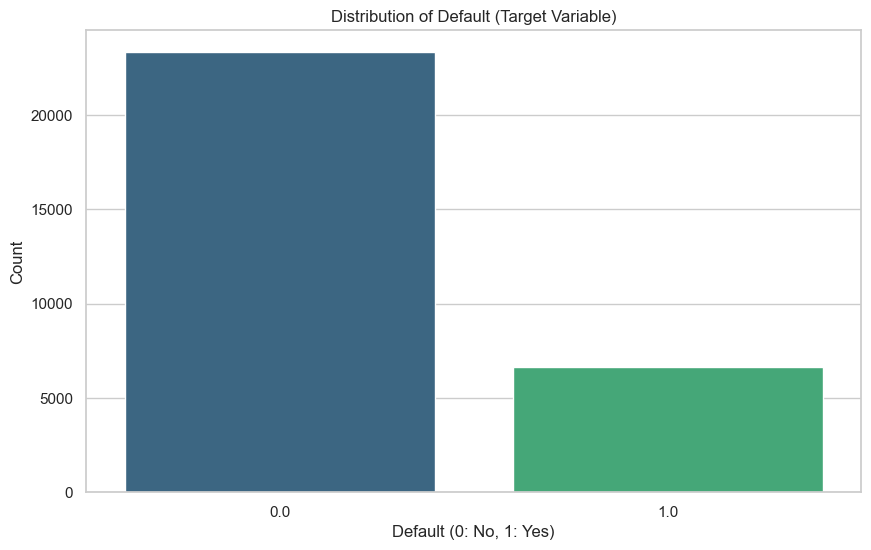

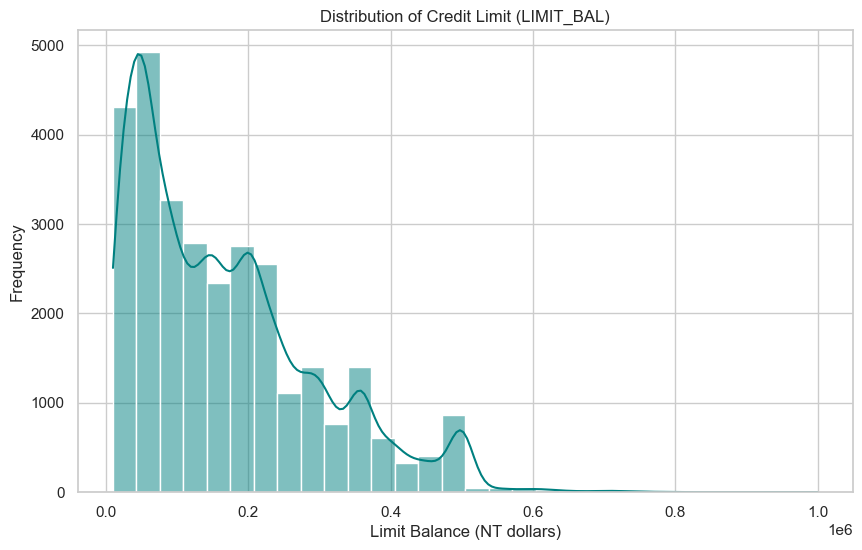

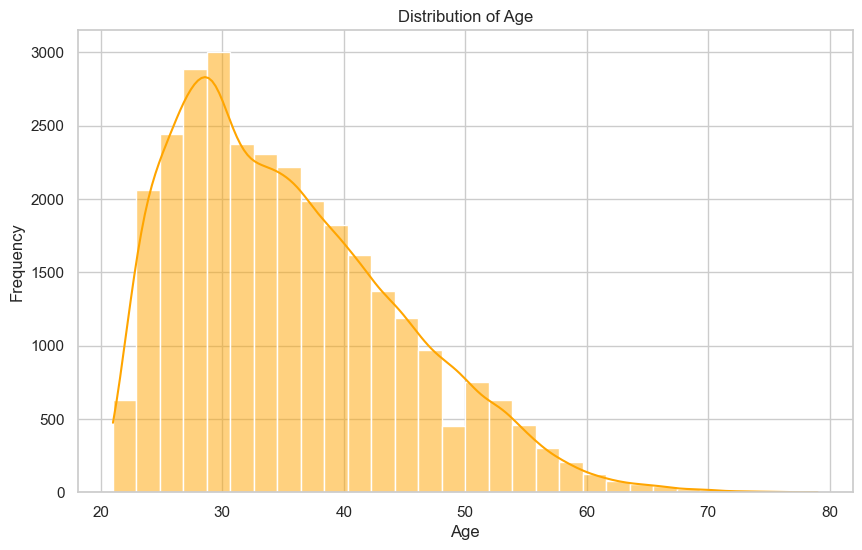

In [10]:
#1. visualize the target variable balance
plt.figure()
sns.countplot(x='default.payment.next.month', data=df, palette='viridis')
plt.title('Distribution of Default (Target Variable)')
plt.xlabel('Default (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

#2. visualize the distribution of Credit Limit (LIMIT_BAL)
plt.figure()
sns.histplot(df['LIMIT_BAL'], bins=30, kde=True, color='teal')
plt.title('Distribution of Credit Limit (LIMIT_BAL)')
plt.xlabel('Limit Balance (NT dollars)')
plt.ylabel('Frequency')
plt.show()

#3. visualize Age distribution
plt.figure()
sns.histplot(df['AGE'], bins=30, kde=True, color='orange')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:

#1. create a copy to avoid SettingWithCopyWarning
df_clean = df.copy()

#2. handle Missing Target Values
#we cannot use data without a label for training/testing, so we drop these rows
df_clean = df_clean.dropna(subset=['default.payment.next.month'])

#3. impute Missing Numerical Values
#'BILL_AMT1' through 'BILL_AMT6' have 150 missing values each.
#we fill these with the median to be robust against outliers seen in the statistics
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
for col in bill_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

#4. impute Missing Categorical Values
#'EDUCATION' and 'MARRIAGE' have small amounts of missing data. We fill with the mode (most frequent value).
cols_to_fill_mode = ['EDUCATION', 'MARRIAGE']
for col in cols_to_fill_mode:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

#5. encode Categorical Variables
#binary Encoding for SEX
df_clean['SEX'] = df_clean['SEX'].map({'female': 0, 'male': 1})

#One-Hot Encoding for 'EDUCATION' and 'MARRIAGE'
#this converts categories into binary columns (e.g., EDUCATION_university: 0 or 1)
#drop_first=True is used to avoid multicollinearity (dummy variable trap)
#added dtype=int to ensure columns are created as integers (0/1) instead of booleans
df_clean = pd.get_dummies(df_clean, columns=['EDUCATION', 'MARRIAGE'], drop_first=True, dtype=int)

#6. Final Cleanup
#drop the 'ID' column as it is an identifier, not a feature
if 'ID' in df_clean.columns:
    df_clean = df_clean.drop('ID', axis=1)

#rename the target column to something shorter and clearer
df_clean.rename(columns={'default.payment.next.month': 'Default'}, inplace=True)

#ensure the target is an integer (it was float due to NaNs previously)
df_clean['Default'] = df_clean['Default'].astype(int)

#verify the cleaning
print("Cleaned Dataframe Shape:", df_clean.shape)
print("\nMissing Values after cleaning:")
print(df_clean.isnull().sum().sum())
print("\nFirst 5 rows of transformed data:")
display(df_clean.head())

Cleaned Dataframe Shape: (29980, 28)

Missing Values after cleaning:
0

First 5 rows of transformed data:


,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,EDUCATION_high school,EDUCATION_others,EDUCATION_university,EDUCATION_unknown,MARRIAGE_other,MARRIAGE_single
0,20000.0,0,24,2,2,0,0,0,0,3913.0,...,0.0,0.0,0.0,1,0,0,1,0,0,0
1,120000.0,0,26,0,2,0,0,0,2,2682.0,...,1000.0,0.0,2000.0,1,0,0,1,0,0,1
2,90000.0,0,34,0,0,0,0,0,0,29239.0,...,1000.0,1000.0,5000.0,0,0,0,1,0,0,1
3,50000.0,0,37,0,0,0,0,0,0,46990.0,...,1100.0,1069.0,1000.0,0,0,0,1,0,0,0
4,50000.0,1,57,0,0,0,0,0,0,8617.0,...,9000.0,689.0,679.0,0,0,0,1,0,0,0


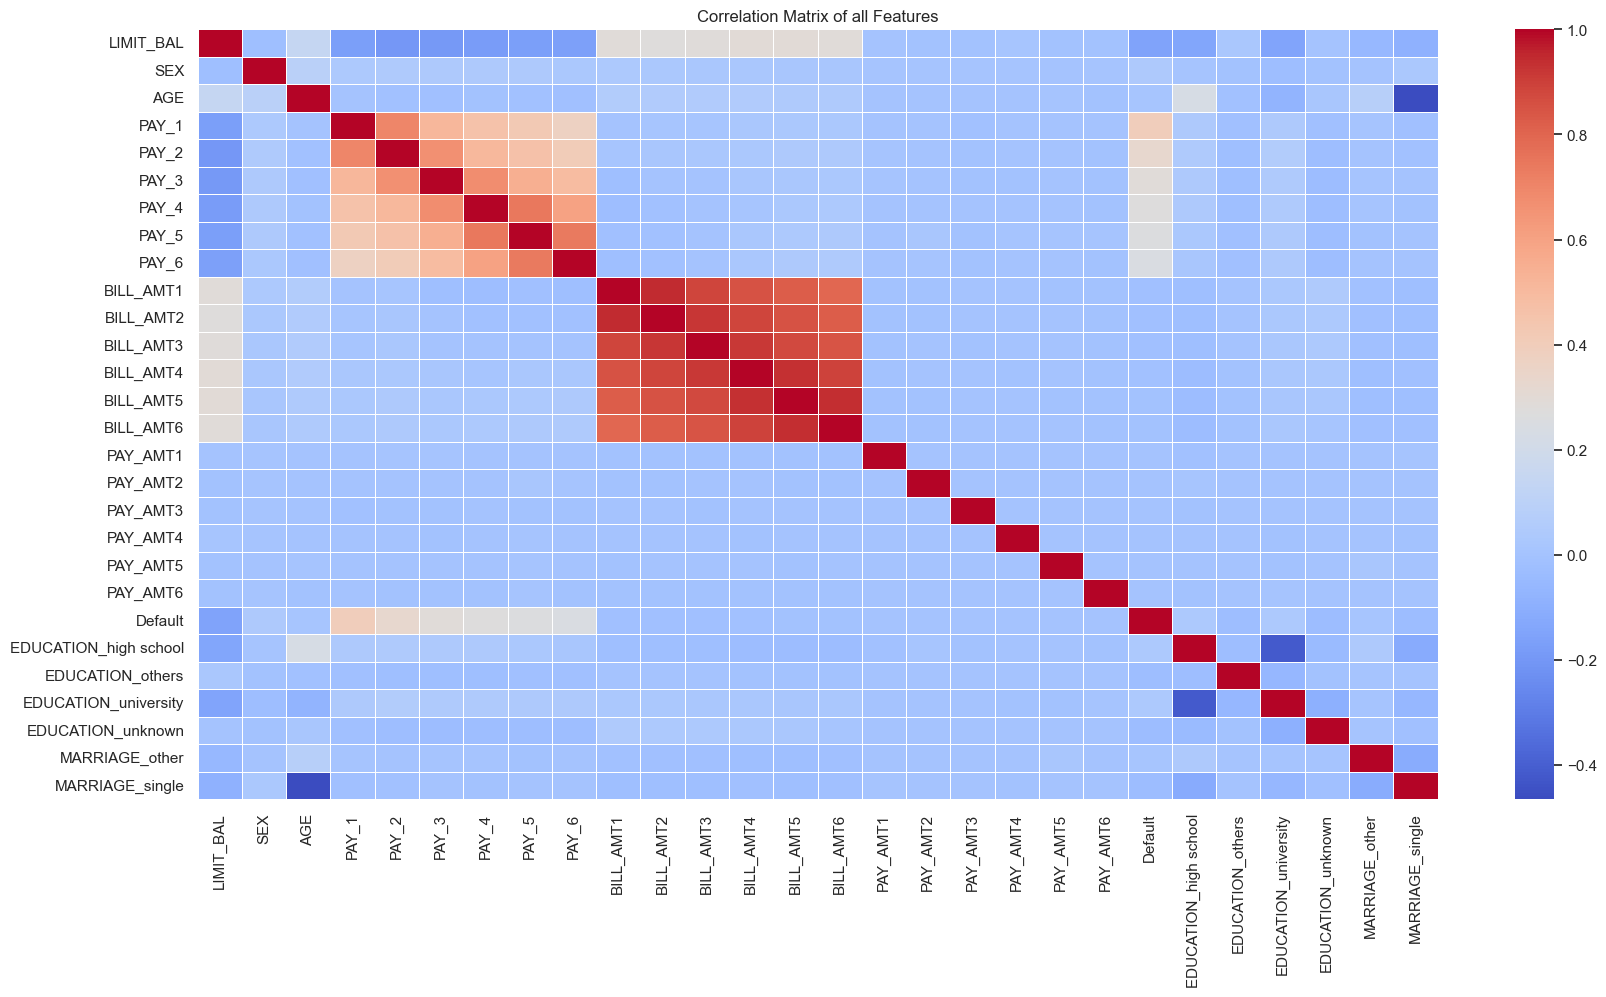

Top 10 Features Correlated with Default:
Default                  1.000000
PAY_1                    0.396114
PAY_2                    0.327166
PAY_3                    0.287063
PAY_4                    0.269124
PAY_5                    0.260927
PAY_6                    0.244508
SEX                      0.039840
EDUCATION_university     0.036142
EDUCATION_high school    0.032427
Name: Default, dtype: float64

Top 10 Features Negatively Correlated with Default:
LIMIT_BAL           -0.153566
EDUCATION_unknown   -0.036330
MARRIAGE_single     -0.031739
EDUCATION_others    -0.025415
BILL_AMT1           -0.019095
BILL_AMT2           -0.014527
BILL_AMT3           -0.013541
BILL_AMT4           -0.009443
BILL_AMT5           -0.006219
BILL_AMT6           -0.004989
Name: Default, dtype: float64


C:\Users\allam\AppData\Local\Temp\ipykernel_17156\832745159.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y='LIMIT_BAL', data=df_clean, palette='viridis')


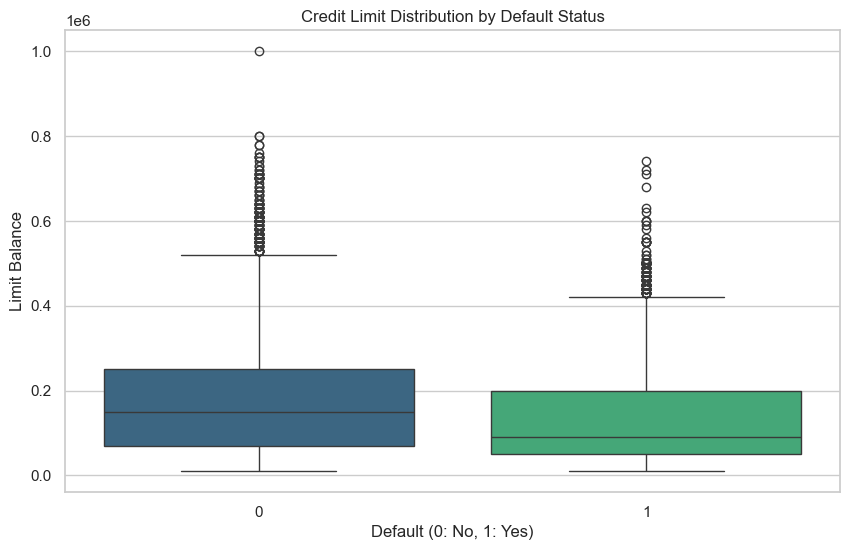

C:\Users\allam\AppData\Local\Temp\ipykernel_17156\832745159.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y='AGE', data=df_clean, palette='viridis')


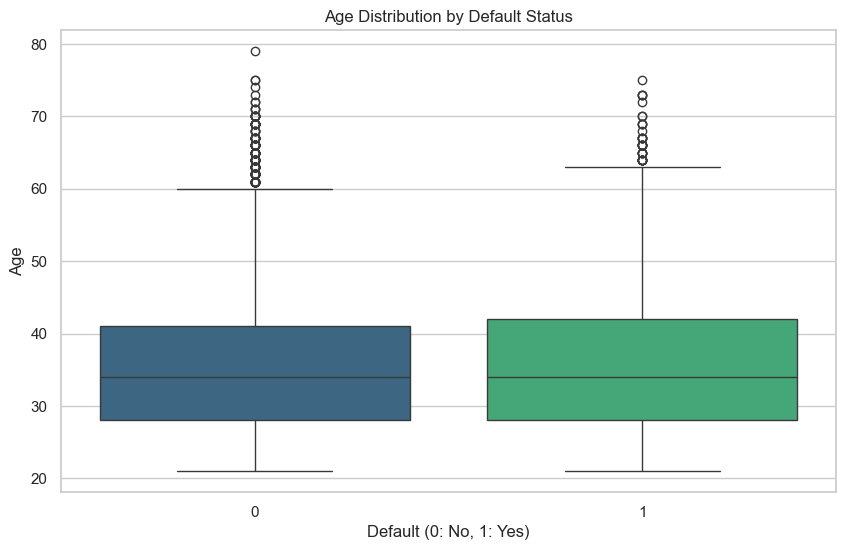

In [ ]:
#1. Correlation Matrix
#we calculate the correlation of all features with each other
plt.figure(figsize=(20, 10))
corr = df_clean.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of all Features')
plt.show()

#2. Check Top Correlations with Target ('Default')
#this helps us identify the most important predictors immediately
print("Top 10 Features Correlated with Default:")
print(corr['Default'].sort_values(ascending=False).head(10))
print("\nTop 10 Features Negatively Correlated with Default:")
print(corr['Default'].sort_values(ascending=True).head(10))

#3. Visualizing Key Features vs Default
#Boxplot for Limit Balance vs Default
plt.figure(figsize=(10, 6))
sns.boxplot(x='Default', y='LIMIT_BAL', data=df_clean, palette='viridis')
plt.title('Credit Limit Distribution by Default Status')
plt.xlabel('Default (0: No, 1: Yes)')
plt.ylabel('Limit Balance')
plt.show()

#Boxplot for Age vs Default
plt.figure(figsize=(10, 6))
sns.boxplot(x='Default', y='AGE', data=df_clean, palette='viridis')
plt.title('Age Distribution by Default Status')
plt.xlabel('Default (0: No, 1: Yes)')
plt.ylabel('Age')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#1. Define Features (X) and Target (y)
X = df_clean.drop('Default', axis=1)
y = df_clean['Default']

#2. Train-Test Split
#we use test_size=0.2 (20% for testing)
#stratify=y ensures both sets have the same proportion of defaulters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#3. Feature Scaling
#initialize the Standard Scaler
scaler = StandardScaler()

#fit only on training data, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#convert arrays back to DataFrames for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

#verify the split and scaling
print("Training Data Shape:", X_train_scaled.shape)
print("Testing Data Shape:", X_test_scaled.shape)
print("\nFirst 5 rows of Scaled Training Data (checking that values are small/normalized):")
display(X_train_scaled.head())

Training Data Shape: (23984, 27)
Testing Data Shape: (5996, 27)

First 5 rows of Scaled Training Data (checking that values are small/normalized):


,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_high school,EDUCATION_others,EDUCATION_university,EDUCATION_unknown,MARRIAGE_other,MARRIAGE_single
0,0.253302,-0.813337,0.059698,-0.471003,-0.400301,-0.384874,-0.341469,-0.309329,-0.318588,-0.695820,...,-0.018267,-0.015819,-0.018267,-0.018267,-0.44484,-0.064381,-0.938825,-0.10489,-0.102632,0.934433
1,-0.904965,-0.813337,-0.484961,0.851776,2.099588,-0.384874,-0.341469,-0.309329,-0.318588,-0.226765,...,-0.018267,-0.015819,-0.018267,-0.018267,-0.44484,-0.064381,1.065161,-0.10489,-0.102632,-1.070168
2,2.569835,-0.813337,1.257948,-0.471003,-0.400301,-0.384874,-0.341469,-0.309329,-0.318588,-0.690458,...,-0.018267,-0.015819,-0.018267,-0.018267,-0.44484,-0.064381,1.065161,-0.10489,-0.102632,-1.070168
3,-0.904965,-0.813337,-1.029620,-0.471003,-0.400301,-0.384874,-0.341469,-0.309329,-0.318588,-0.671395,...,-0.018267,-0.015819,-0.018267,-0.018267,-0.44484,-0.064381,1.065161,-0.10489,-0.102632,-1.070168
4,-0.904965,1.229503,-1.138552,-0.471003,-0.400301,-0.384874,-0.341469,-0.309329,-0.318588,-0.617103,...,-0.018267,-0.015819,-0.018267,-0.018267,-0.44484,-0.064381,1.065161,-0.10489,-0.102632,0.934433
